# [ICR] Epsilon Model

 
Train TestnにGreeksデータからEpsilonを使ってモデルを作成する

In [1]:
!pip install tabpfn

# **Libraries**

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from tabpfn import TabPFNClassifier

import torch
from tabpfn import TabPFNClassifier

# **データのダウンロード**

In [3]:
train_df  = pd.read_csv('./data/train.csv')
test_df   = pd.read_csv('./data/test.csv')
greeks_df = pd.read_csv('./data/greeks.csv')
sample_submission = pd.read_csv('./data/sample_submission.csv')

# **Auto Featで得た特徴量を追加してモデルを構築する**

カテゴリ値を数字にする

In [4]:
train_df['EJ'] = train_df['EJ'].replace('A', 0).replace('B', 1)
train_df['EJ']

0      1
1      0
2      1
3      1
4      1
      ..
612    0
613    1
614    0
615    1
616    0
Name: EJ, Length: 617, dtype: int64

In [5]:
test_df['EJ'] = test_df['EJ'].replace('A', 0).replace('B', 1)
test_df['EJ']

0    0
1    0
2    0
3    0
4    0
Name: EJ, dtype: int64

# **EJ列のA:0　B:1で分布を見てみる。**
# **EJ列が男性か女性である場合、差がある特徴量によって特徴量の内容をある程度予想ができるかもしれない。**

In [6]:
df = train_df.drop('Id', axis=1)

C:\Users\user\AppData\Local\Temp\ipykernel_7484\2726777368.py:22: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=EJ1_df, fill=False, x=col, color='#FFBE7B', legend=False)
C:\Users\user\AppData\Local\Temp\ipykernel_7484\2726777368.py:32: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=EJ0_df, fill=False, x=col, color='#4C72B0', legend=False)


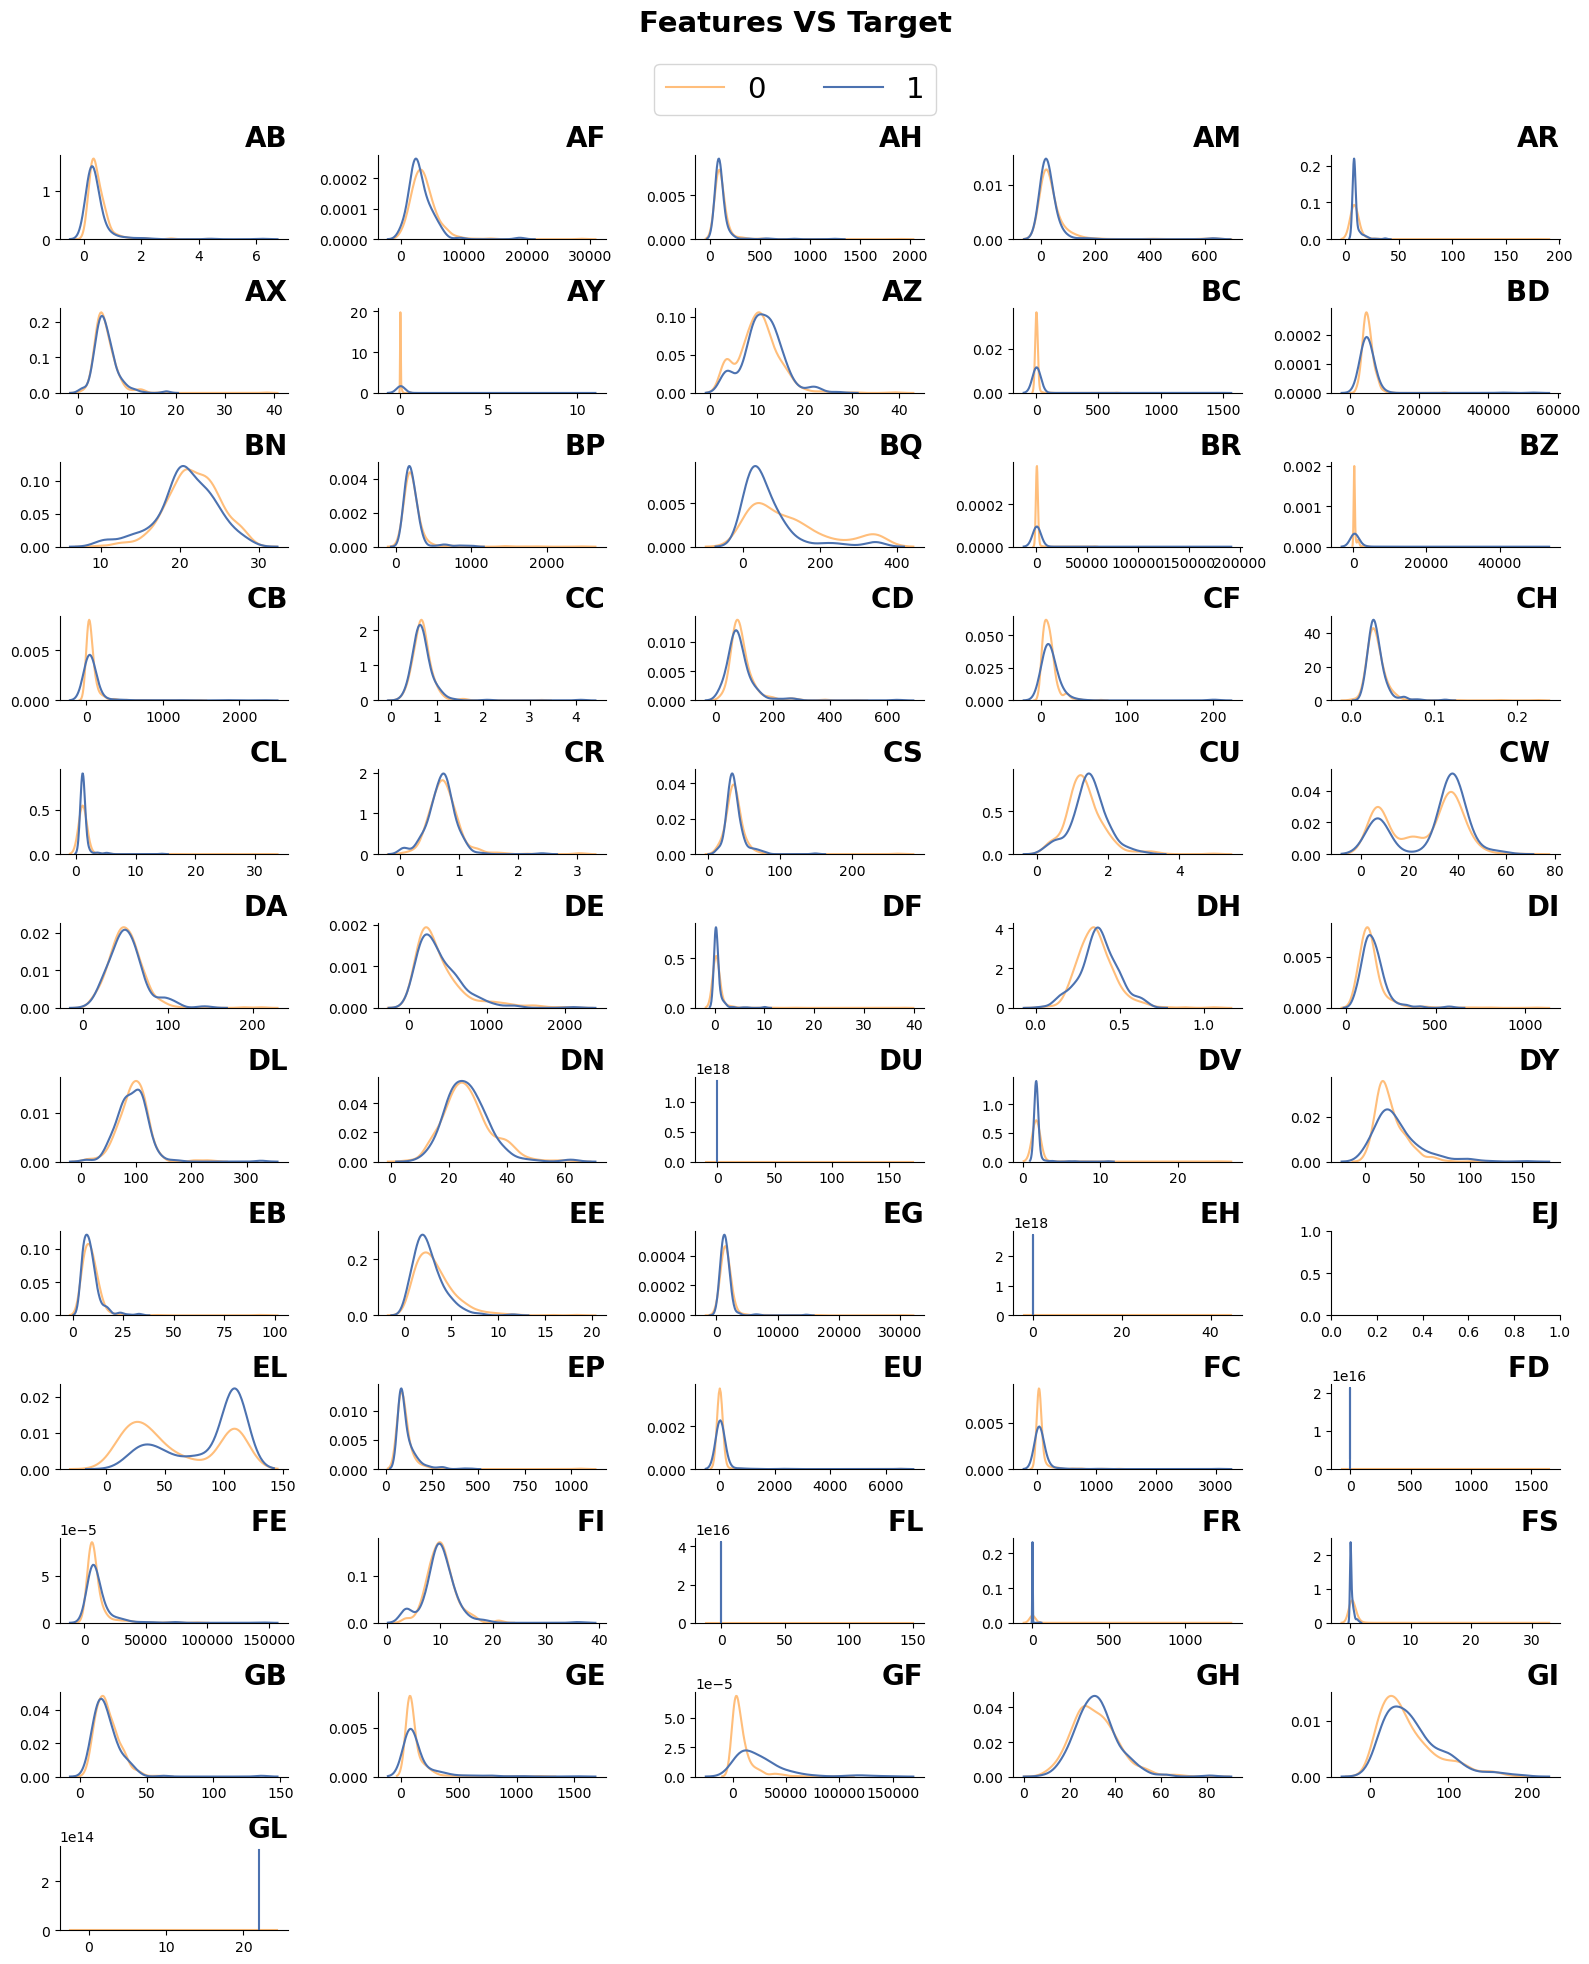

In [7]:
import pandas as pd
def plot_kde(df: pd.DataFrame, sub_row=12, sub_col=5, figsize=(4 * 4, 20)):
    """
    KDEプロットの作成(EJ: 1　と　0　に分ける)
    """
    figsize = figsize
    fig = plt.figure(figsize=figsize)
    
    #EJ：1　のデータを抽出
    EJ1_df = df[df['EJ'] == 1]
    #Class列を除いた特徴量
    EJ1_cols = EJ1_df.columns[:-1]
    
    #EJ：0　のデータ抽出
    EJ0_df = df[df['EJ'] == 0]
    #Class列を除いた特徴量
    EJ0_cols = EJ0_df.columns[:-1]
        
  
    for idx, col in enumerate(EJ1_cols):
        ax = plt.subplot(sub_row, sub_col, idx + 1)
        sns.kdeplot(data=EJ1_df, fill=False, x=col, color='#FFBE7B', legend=False)
        
        ax.set_ylabel('')
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('')
        ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=20)
        
    for idx, col in enumerate(EJ0_cols):
        ax = plt.subplot(sub_row, sub_col, idx + 1)
        sns.kdeplot(data=EJ0_df, fill=False, x=col, color='#4C72B0', legend=False)
        
        ax.set_ylabel('')
        ax.spines['top'].set_visible(False)
        ax.set_xlabel('')
        ax.spines['right'].set_visible(False)
        ax.set_title(f'{col}', loc='right', weight='bold', fontsize=20)
        
    fig.suptitle(
        f'Features VS Target\n\n\n', ha='center', fontweight='bold', fontsize=21
    )
    fig.legend(
        [0, 1], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=21, ncol=3
    )
    plt.tight_layout()
    plt.show

plot_kde(df)

In [8]:
df.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


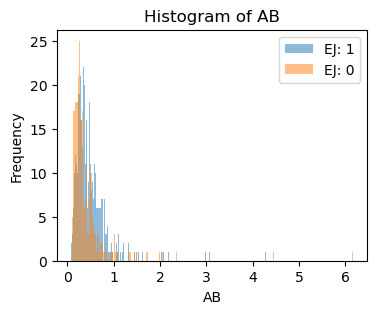

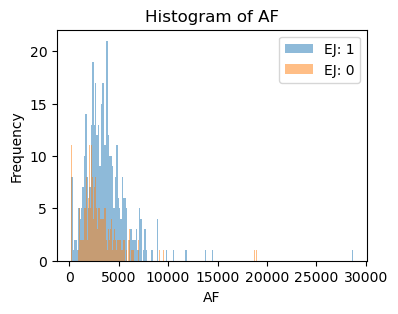

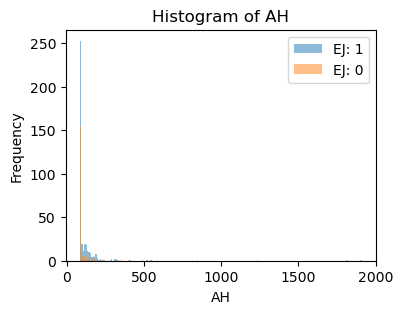

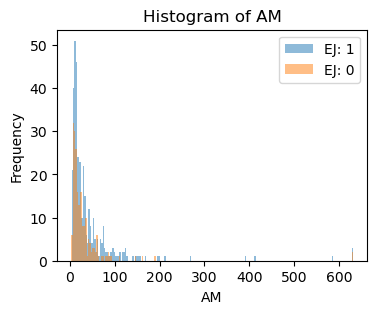

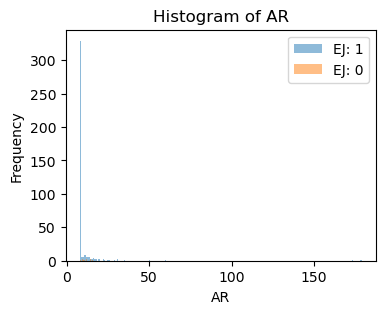

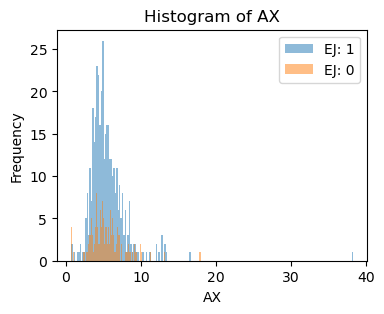

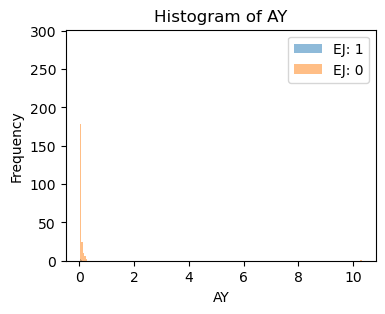

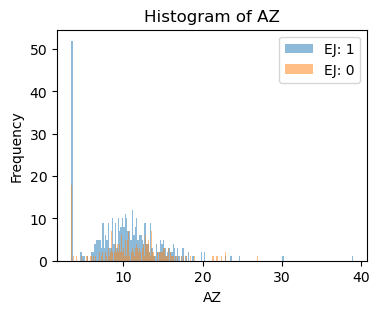

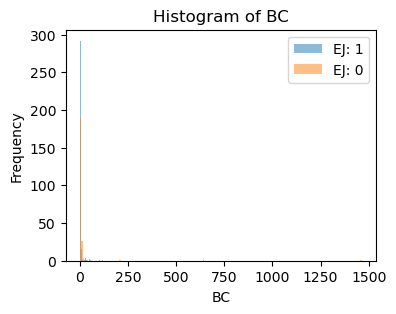

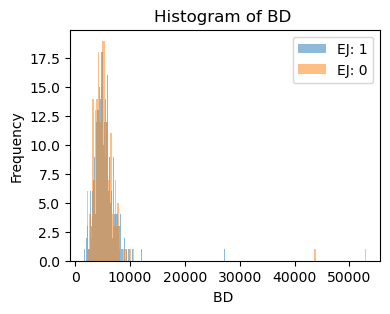

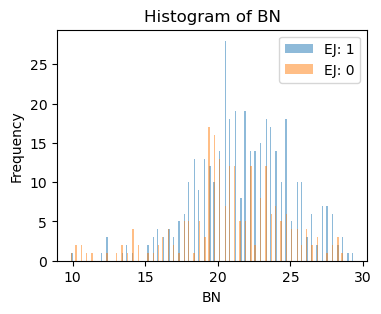

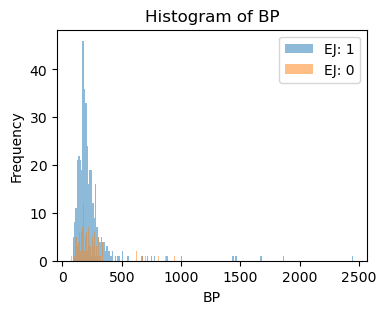

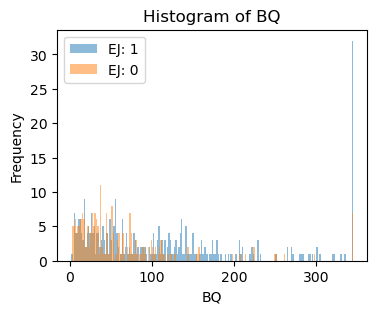

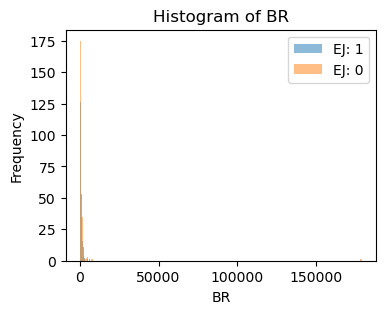

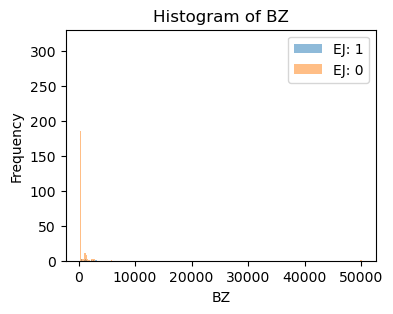

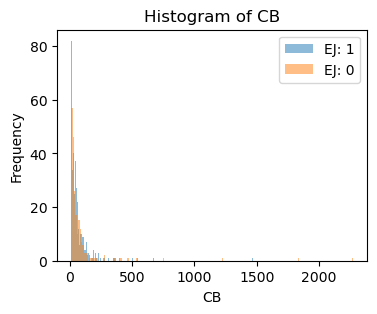

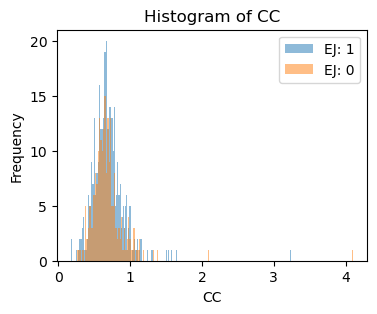

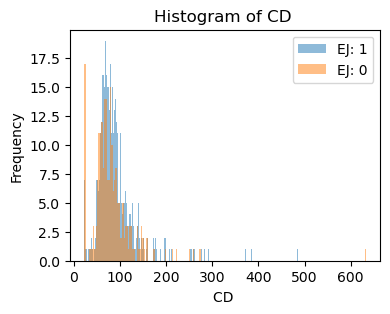

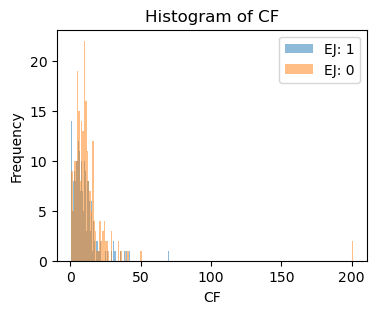

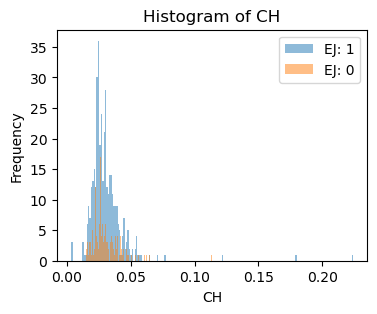

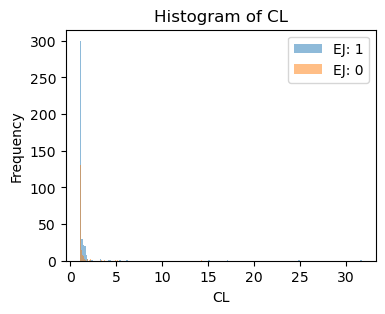

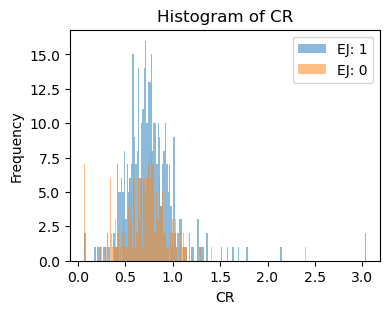

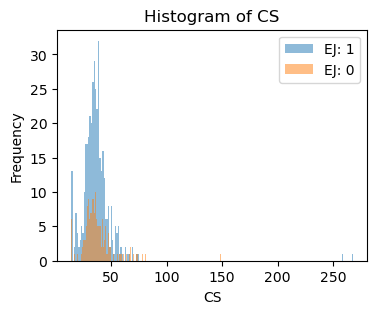

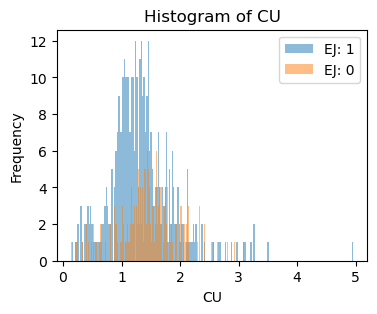

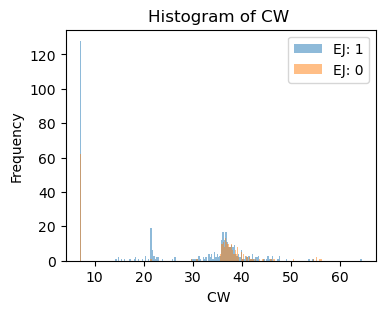

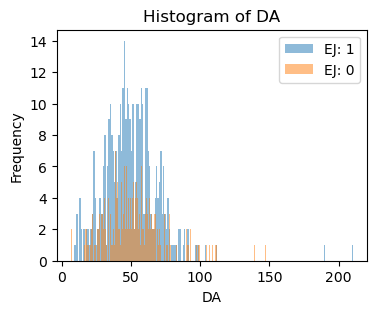

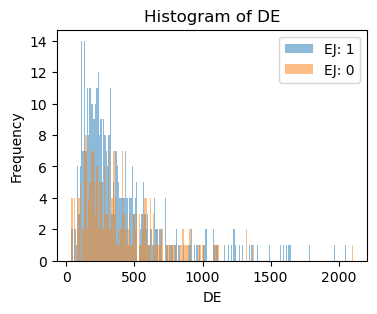

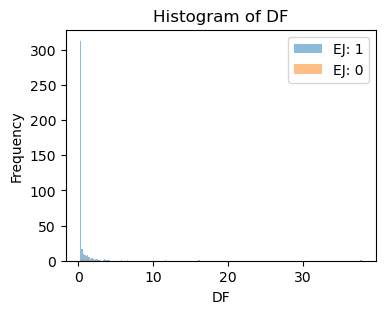

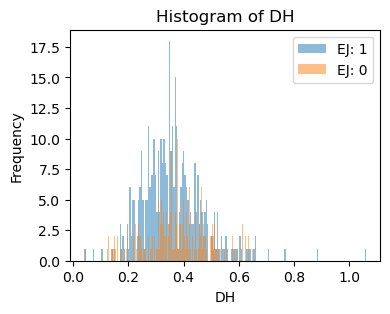

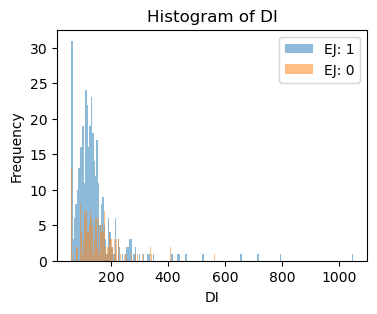

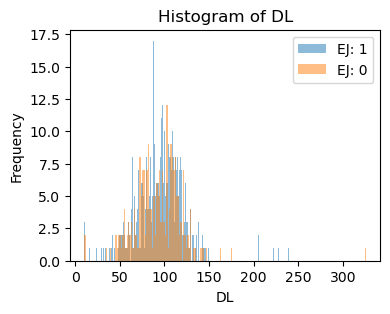

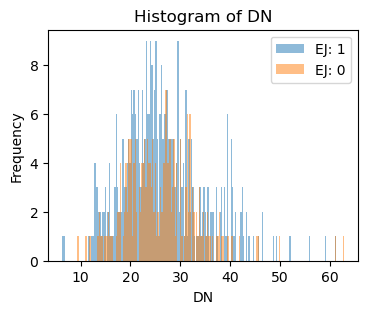

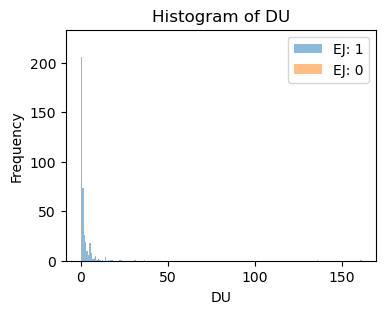

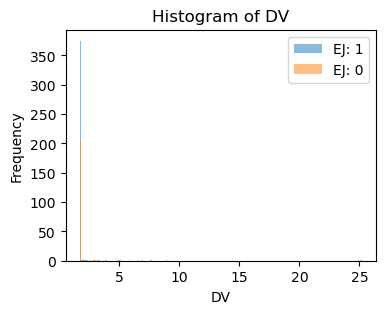

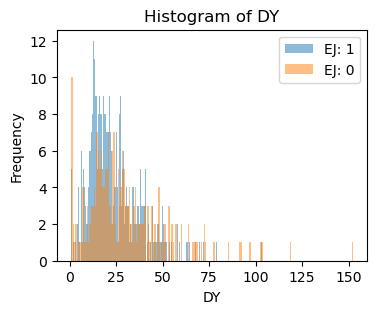

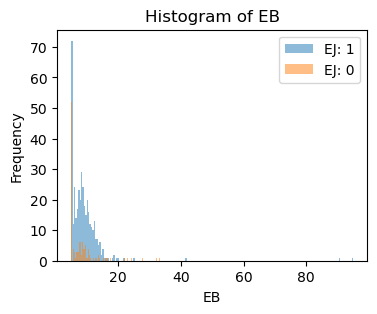

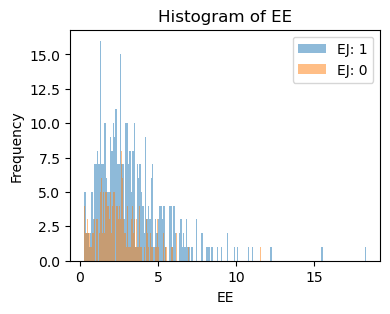

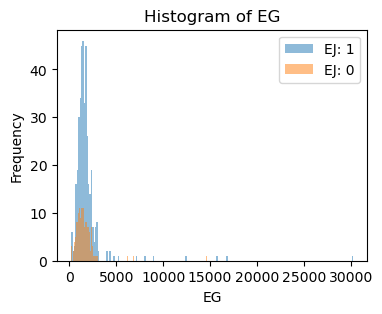

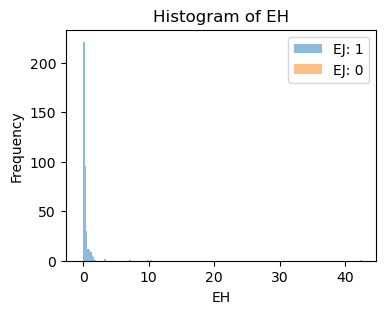

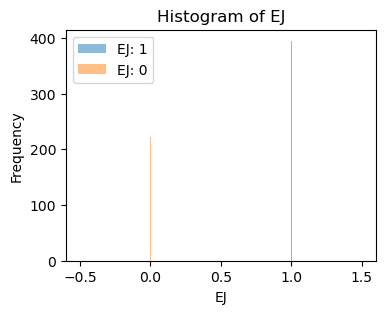

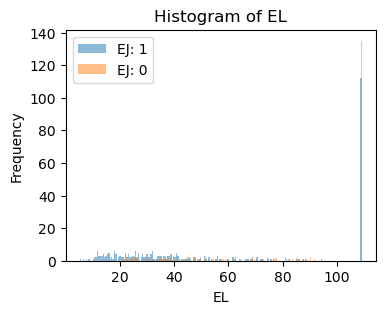

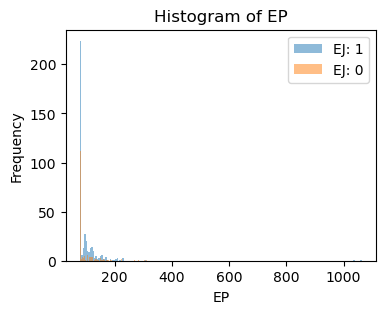

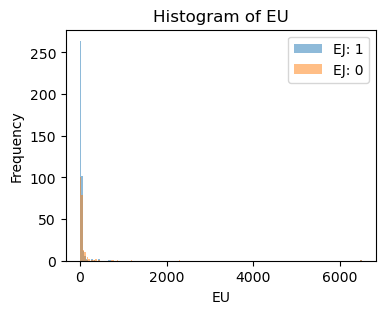

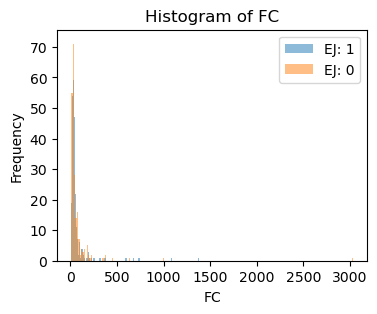

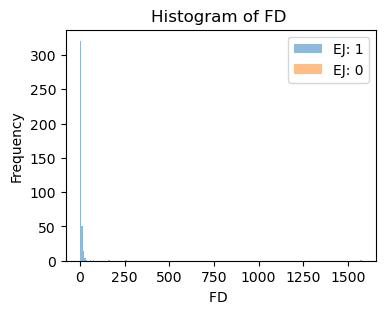

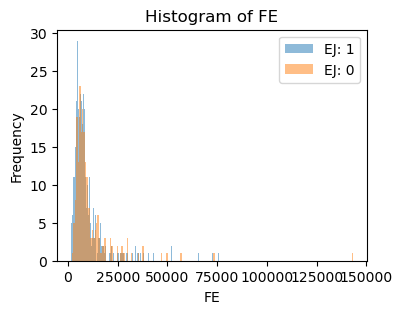

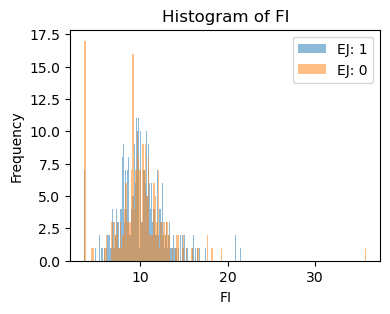

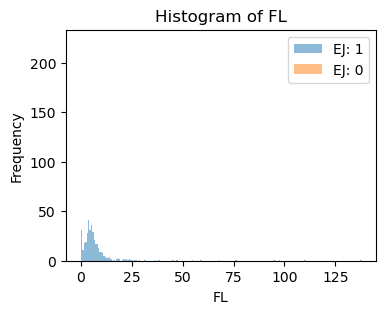

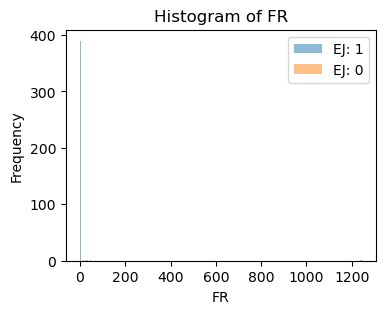

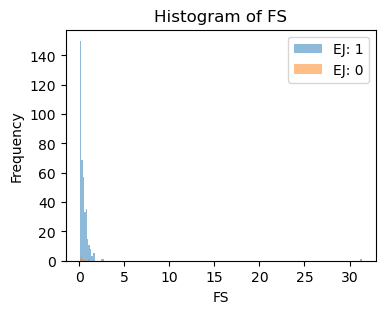

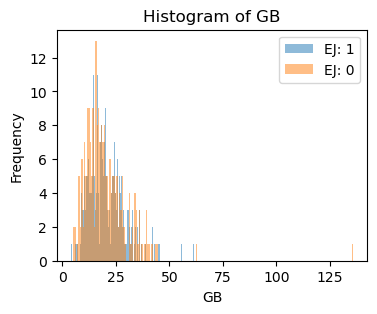

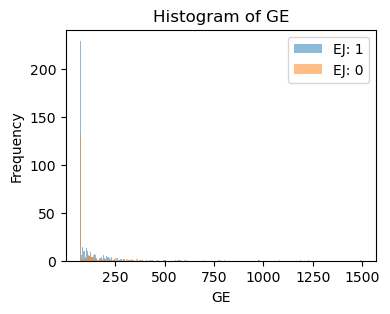

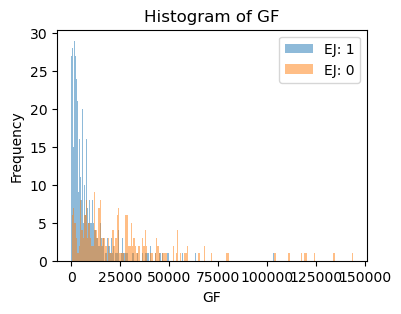

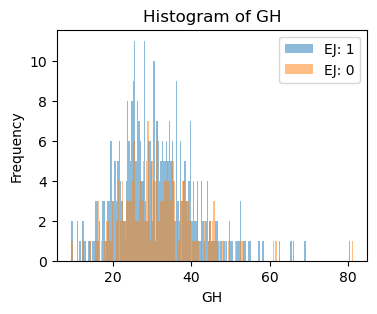

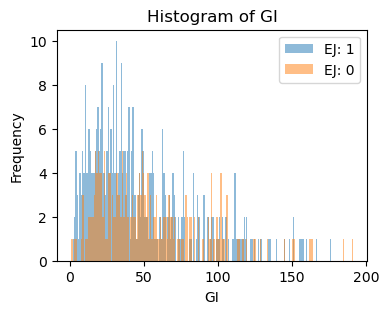

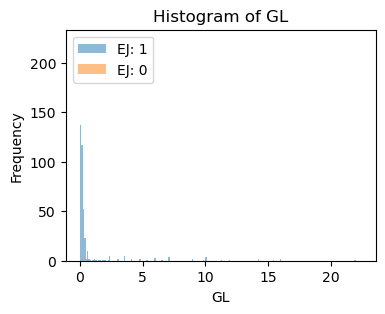

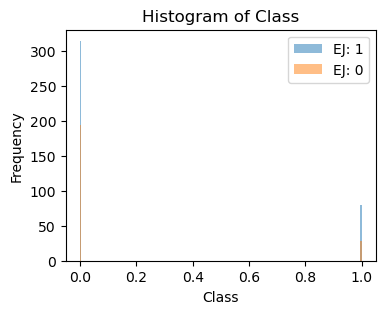

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms(df: pd.DataFrame):
    """
    各カラムごとにEJ列が1と0で分かれたヒストグラムを作成する
    """
    columns = df.columns.tolist()
    ej_values = df['EJ'].unique()

    # 各カラムに対してヒストグラムを作成
    for col in columns:
        plt.figure(figsize=(4, 3))

        # EJ列が1のデータのヒストグラムを作成
        plt.hist(df[df['EJ'] == 1][col], bins=200, alpha=0.5, label='EJ: 1')

        # EJ列が0のデータのヒストグラムを作成
        plt.hist(df[df['EJ'] == 0][col], bins=200, alpha=0.5, label='EJ: 0')

        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.title(f'Histogram of {col}')
        plt.legend()
        plt.show()
        
plot_histograms(df)

欠損値を-999で補完する

In [10]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


カラム名の不要なスペースを削除する

In [11]:
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

In [12]:
all_cols = train_df.columns
non_use_cols = ['Id', 'Class']
feature_cols = [col for col in all_cols if col not in non_use_cols]
print(feature_cols)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']


In [13]:
train_df[feature_cols] = train_df[feature_cols].fillna(-999)
test_df[feature_cols] = test_df[feature_cols].fillna(-999)

'sqrt(EH)/GL', 'FE/DA', 'AB/FS', 'log(FR)/FE', 'log(DY)/CC'

を特徴量に追加する。(ICR AutoFeatより）

In [14]:
train_df['sqrt(EH)/GL'] = np.sqrt(train_df['EH']) / train_df['GL']
train_df['FE/DA'] = train_df['FE'] / train_df['DA']
train_df['AB/FS'] = train_df['AB'] / train_df['FS']
train_df['log(FR)/FE'] = np.log(train_df['FR']) / train_df['FE']
train_df['log(DY)/CC'] = np.log(train_df['DY']) / train_df['CC']

train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,Class,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,2003.810319,22.136229,69.834944,0.120343,1,8.095368,130.686850,2.208106,0.000061,5.578935
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,27981.562750,29.135430,32.131996,21.978000,0,0.002510,95.835602,0.255359,-0.000103,5.871977
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,13676.957810,28.022851,35.192676,0.196941,0,3.118559,117.748397,0.392077,-0.000003,7.274684
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,2094.262452,39.948656,90.493248,0.155829,0,5.030466,231.952756,0.886247,-0.000064,5.504133
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8524.370502,45.381316,36.262628,0.096614,1,4.195023,218.699515,3.119387,0.000240,4.109116


In [15]:
test_df['sqrt(EH)/GL'] = np.sqrt(test_df['EH']) / test_df['GL']
test_df['FE/DA'] = test_df['FE'] / test_df['DA']
test_df['AB/FS'] = test_df['AB'] / test_df['FS']
test_df['log(FR)/FE'] = np.log(test_df['FR']) / test_df['FE']
test_df['log(DY)/CC'] = np.log(test_df['DY']) / test_df['CC']

test_df.head()

C:\Users\user\anaconda3\envs\ICR2\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\user\anaconda3\envs\ICR2\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GE,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf


# **Epsilonを追加する。TestデータにはTrainデータのMax値＋１を追加する。**

In [16]:
from datetime import datetime
times = greeks_df.Epsilon.copy()
times[greeks_df.Epsilon != 'Unknown'] = greeks_df.Epsilon[greeks_df.Epsilon != 'Unknown'].map(lambda x: datetime.strptime(x,'%m/%d/%Y').toordinal())
times[greeks_df.Epsilon == 'Unknown'] = np.nan

In [17]:
times.head()

0    737137.0
1         NaN
2         NaN
3         NaN
4    737509.0
Name: Epsilon, dtype: object

In [18]:
all_cols2 = train_df.columns
non_use_cols = ['Id', 'Class']
feature_cols2 = [col for col in all_cols2 if col not in non_use_cols]
print(feature_cols2)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'sqrt(EH)/GL', 'FE/DA', 'AB/FS', 'log(FR)/FE', 'log(DY)/CC']


In [19]:
train_pred_and_time = pd.concat((train_df, times), axis=1)
test_df['Epsilon'] = train_pred_and_time.Epsilon.max() + 1

In [20]:
train_pred_and_time.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GH,GI,GL,Class,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC,Epsilon
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,22.136229,69.834944,0.120343,1,8.095368,130.686850,2.208106,0.000061,5.578935,737137.0
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,29.135430,32.131996,21.978000,0,0.002510,95.835602,0.255359,-0.000103,5.871977,NaN
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,28.022851,35.192676,0.196941,0,3.118559,117.748397,0.392077,-0.000003,7.274684,NaN
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,39.948656,90.493248,0.155829,0,5.030466,231.952756,0.886247,-0.000064,5.504133,NaN
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,45.381316,36.262628,0.096614,1,4.195023,218.699515,3.119387,0.000240,4.109116,737509.0


In [21]:
train_pred_and_time['Class'].value_counts

<bound method IndexOpsMixin.value_counts of 0      1
1      0
2      0
3      0
4      1
      ..
612    0
613    0
614    0
615    0
616    0
Name: Class, Length: 617, dtype: int64>

In [22]:
train_pred_and_time['Epsilon'].value_counts

<bound method IndexOpsMixin.value_counts of 0      737137.0
1           NaN
2           NaN
3           NaN
4      737509.0
         ...   
612    737681.0
613    737676.0
614    737264.0
615    737090.0
616         NaN
Name: Epsilon, Length: 617, dtype: object>

In [23]:
train_pred_and_time['Epsilon'] = train_pred_and_time['Epsilon'].astype("Int64")

In [24]:
test_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC,Epsilon
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0


外れ値のある行を削除する

In [25]:
train_pred_and_time = train_pred_and_time.drop(index=[160, 511])

# **XGBoostを使ってモデルを構築する**

In [26]:
all_cols3 = train_pred_and_time.columns
non_use_cols = ['Id', 'Class']
feature_cols3 = [col for col in all_cols3 if col not in non_use_cols]
print(feature_cols3)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'sqrt(EH)/GL', 'FE/DA', 'AB/FS', 'log(FR)/FE', 'log(DY)/CC', 'Epsilon']


In [27]:

y = train_pred_and_time['Class']
x = train_pred_and_time[feature_cols3]

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ベストモデルを使用して評価
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBClassifier(**params)
    # ハイパーパラメータのグリッドを定義
    param_grid = {
        'max_depth': [3, 5, 7],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    # GridSearchCVを使用してハイパーパラメータのチューニング
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
    grid_search.fit(X_train, y_train)
    
    # 最適なモデルとハイパーパラメータを取得
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    print("Best Parameters:", best_params)
    
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict_proba(X_test)[:, 1]
    score = log_loss(y_test, y_pred)
    scores.append(score)
    
mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')


Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6}
Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.6}
Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.8}
Best Parameters: {'colsample_bytree': 0.6, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 1.0}
Best Parameters: {'colsample_bytree': 0.8, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.8}
Logloss_Score 1: 0.14817264524538318
Logloss_Score 2: 0.0825250918567039
Logloss_Score 3: 0.2947165723692063
Logloss_Score 4: 0.1598499125313572
Logloss_Score 5: 0.1594047042274496
Logloss_mean: 0.16893378524602


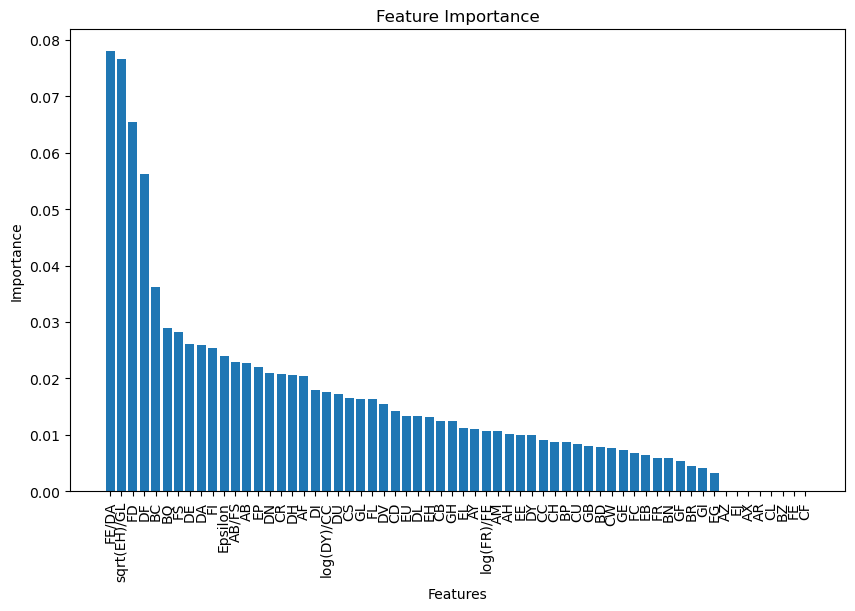

In [28]:

importance = best_model.feature_importances_
feature_names = feature_cols3

# 重要度の高い順に特徴量をソート
sorted_indices = importance.argsort()[::-1]
sorted_importance = importance[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.bar(sorted_feature_names, sorted_importance)
plt.xticks(rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [29]:
test = test_df.drop('Id', axis=1)
test.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC,Epsilon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0


In [30]:
"""
pred = pd.DataFrame(best_model.predict_proba(test))
"""


'\npred = pd.DataFrame(best_model.predict_proba(test))\n'

In [31]:
"""
sample_submission['Id']      = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('submission.csv')
sample_submission
"""


'\nsample_submission[\'Id\']      = test_df.reset_index()[\'Id\']\nsample_submission["class_0"] = pred[0]\nsample_submission["class_1"] = pred[1]\nsample_submission.set_index(\'Id\').to_csv(\'submission.csv\')\nsample_submission\n'

# **XGB CV 0.168**

# **XGBとTabPFNのアンサンブルでモデルを作成する**

In [33]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from catboost import Pool, CatBoostClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import xgboost as xgb

class WeightedEnsemble(BaseEstimator, ClassifierMixin):
    def __init__(self, xgb_params=None):
        self.xgb_params = xgb_params
        self.classifiers = [
            xgb.XGBClassifier(**params) for params in self.xgb_params
        ]
        self.classifiers.append(TabPFNClassifier())  # TabPFNClassifierを追加

    def fit(self, X_train, y_train):
        unique_classes, y_train = np.unique(y_train, return_inverse=True)
        self.classes_ = unique_classes
        for classifier in self.classifiers:
            classifier.fit(X_train, y_train)

    def predict_proba(self, X_train):
        probabilities = np.stack([classifier.predict_proba(X_train) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1)

In [35]:
y = train_pred_and_time['Class']
x = train_pred_and_time[feature_cols3]

In [36]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ベストモデルを使用して評価
scores = []
for train_index, test_index in skf.split(x, y):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    model = WeightedEnsemble(xgb_params=[
        {
            'learning_rate': 0.1,
            'n_estimators': 100,
            'random_state': 0,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'eta': 0.1,
            'colsample_bytree': 0.8,
            'max_depth': 3,
            'min_child_weight': 1,
            'subsample': 0.8
        }
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)[:, 1]
    score = log_loss(y_test, y_pred)
    scores.append(score)

mean_score = sum(scores) / len(scores)
for i, score in enumerate(scores):
    print(f'Logloss_Score {i+1}: {score}')

print(f'Logloss_mean: {mean_score}')

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Logloss_Score 1: 0.1876922892430122
Logloss_Score 2: 0.14042728201641802
Logloss_Score 3: 0.24196768513808575
Logloss_Score 4: 0.22902406499443143
Logloss_Score 5: 0.2149754552758572
Logloss_mean: 0.2028173553335609


In [37]:
test = test_df.drop('Id', axis=1)
test.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,GF,GH,GI,GL,sqrt(EH)/GL,FE/DA,AB/FS,log(FR)/FE,log(DY)/CC,Epsilon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,-inf,-inf,737698.0


In [38]:
pred = pd.DataFrame(model.predict_proba(test))

In [39]:

sample_submission['Id']      = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('submission.csv')
sample_submission



,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


# **WeightedEnsemble**
# **LB 0.21 CV 0.202****